In [2]:
import os, sys
import numpy as np

In [13]:
from skimage import io
import pandas as pd
import json

In [4]:
import anndata
import scanpy as sc
import squidpy as sq

In [5]:
data_root = r"E:\LungIMCData\HumanSampling35\LungROIProcessing\Steinbock"

In [6]:
test_roi_name = "H17-0458-5-ROI016"

### Load steinbock exported AnnData

In [7]:
roi_h5ad_path = os.path.join(data_root, "rois_h5ad", "{}.h5ad".format(test_roi_name))
roi_adata = sc.read_h5ad(roi_h5ad_path)

### Load cell phenotype information

In [10]:
cell_phenotype_dict = None
cell_phenotype_path = os.path.join(data_root, "cell_phenotypes.json")
with open(cell_phenotype_path) as fp:
    cell_phenotype_dict = json.load(fp)
cell_ids = [ele for ele in cell_phenotype_dict.keys()]
roi_phenotypes_dict = {}
library_id_dict = {}
cell_num_dict = {}
# collect roi list
roi_lst = []
for cell_id in cell_ids:
    roi_name = cell_id[:cell_id.rfind("_")]
    if roi_name not in roi_lst:
        roi_lst.append(roi_name)
# collect roi cell numbers
roi_cell_dict = {}
for cell_id in cell_ids:
    roi_name = cell_id[:cell_id.rfind("_")]
    if roi_name not in roi_cell_dict:
        roi_cell_dict[roi_name] = 1
    else:   
        roi_cell_dict[roi_name] += 1
# collect cell_phenotypes
for roi_name in roi_lst:
    cell_num = roi_cell_dict[roi_name]
    cell_phenotypes = [cell_phenotype_dict[roi_name + "_" + str(num)] for num in range(1, cell_num + 1)]
    roi_library_ids = [roi_name, ] * cell_num
    cell_nums = [ele for ele in range(1, cell_num + 1)]
    roi_phenotypes_dict[roi_name] = pd.Categorical(cell_phenotypes) 
    library_id_dict[roi_name] = pd.Categorical(roi_library_ids) 
    cell_num_dict[roi_name] = cell_nums
# add to roi_adata
roi_adata.obs["cell_type"] = roi_phenotypes_dict[test_roi_name]
roi_adata.obs["library_id"] = library_id_dict[test_roi_name]
roi_adata.obs["cell_id"] = cell_num_dict[test_roi_name]

### Add spatial coordinates

In [11]:
spatial_coords = np.transpose(np.asarray([roi_adata.obs["centroid-1"].tolist(), roi_adata.obs["centroid-0"].tolist()]))
roi_adata.obsm["spatial"] = spatial_coords

In [ ]:
### Add image & segemntation information

In [19]:
rois_img_dict = {}
roi_img_path = os.path.join(data_root, "img", test_roi_name + ".tiff")
roi_imgs = io.imread(roi_img_path, plugin="tifffile")
roi_imgs = np.moveaxis(roi_imgs, 0, 2)
# for ind in range(len(roi_imgs)):
#     roi_imgs[ind] = 255.0 * roi_imgs[ind] / np.max(roi_imgs[ind])   
# roi_imgs = roi_imgs.astype(np.uint8)
roi_seg_path = os.path.join(data_root, "masks_deepcell", test_roi_name + ".tiff")
roi_seg = io.imread(roi_seg_path, plugin="tifffile")
roi_img_dict = {"hires": roi_imgs, "segmentation": roi_seg}
rois_img_dict[test_roi_name] = {}
rois_img_dict[test_roi_name]["images"] = roi_img_dict
rois_img_dict[test_roi_name]["scalefactors"] = {
    'spot_diameter_fullres': 8,
    'tissue_hires_scalef': 1,
    'tissue_segmentation_scalef': 1}
roi_adata.uns["spatial"] = rois_img_dict

### Vis cell segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


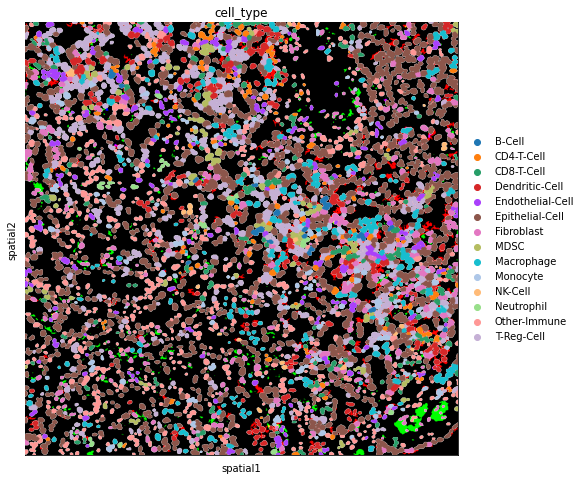

In [20]:
sq.pl.spatial_segment(roi_adata, color="cell_type", library_id=test_roi_name, library_key="library_id", seg_cell_id="cell_id", figsize=(8, 8))

### Convert to ImageContainer

In [22]:
img = sq.im.ImageContainer(roi_adata.uns["spatial"][test_roi_name]["images"]["hires"], library_id=test_roi_name)
img.add_img(roi_adata.uns["spatial"][test_roi_name]["images"]["segmentation"], library_id=test_roi_name, layer="segmentation")
img["segmentation"].attrs["segmentation"] = True

In [23]:
img.interactive(roi_adata, library_key='library_id')

Interactive view of ImageContainer[shape=(800, 800), layers=['image', 'segmentation']]

ERROR: Unable to set library id from `(1, 400)`
ERROR: Unable to set library id from `(1, 1)`
ERROR: Unable to set library id from `(0, 0)`


In [24]:
# img.show("image", channelwise=True)
# img.show("image", segmentation_layer="segmentation", channelwise=True)